In [2]:
from nltk.tokenize import sent_tokenize

import ollama

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances


from reco_systems.filter import filter_df
from reco_systems.llm import *
from reco_systems.CF_knn import *
from reco_systems.user_game_matrix import *
from reco_systems.evaluation import *
from reco_systems.text_filtering import *
from reco_systems.lemmatization import *
from reco_systems.embeds_utils import *

from sklearn.feature_extraction.text import CountVectorizer
from treetaggerwrapper import TreeTagger
from nltk.corpus import stopwords
from nltk import word_tokenize
import textwrap
from string import punctuation
from unicodedata import normalize
from unidecode import unidecode
from itertools import product


sns.set_theme()
%load_ext autoreload
%autoreload 2

/Users/bsh2022/Study/venv/lib/python3.11/site-packages/treetaggerwrapper.py:739: FutureWarning: Possible nested set at position 8
  punct2find_re = re.compile("([^ ])([[" + ALONEMARKS + "])",
/Users/bsh2022/Study/venv/lib/python3.11/site-packages/treetaggerwrapper.py:2043: FutureWarning: Possible nested set at position 152
  DnsHostMatch_re = re.compile("(" + DnsHost_expression + ")",
/Users/bsh2022/Study/venv/lib/python3.11/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/bsh2022/Study/venv/lib/python3.11/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [3]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)

rev_filter = rev_filter.assign(index=rev_filter.index)
rev_filter["Length"] = rev_filter["Comment body"].str.split().apply(len)

lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv")
#lemmas = lemmas[~lemmas["Lemma"].isna()]
corpus = construction_corpus(lemmas, 5000)
lemmas = lemmas[lemmas["Lemma"].isin(corpus)]

comments_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index()
rev_filter = rev_filter[rev_filter["index"].isin(comments_lemmatized["Comment line"])]
comments_lemmatized = comments_lemmatized.merge(rev_filter[["Game id", "User id", "index"]], left_on="Comment line", right_on="index")

rev_filter, _ = center_score(rev_filter)
users_means = rev_filter[["User id", "Rating"]].groupby("User id").mean().reset_index()

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


# Phrase embeddings with `BAAI/BG3`

### Sentence splitting

In [3]:
# rev_filter_embed = rev_filter.copy()

# # Unicode normalization
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].apply(lambda row : normalize("NFKC", row))

# # Replace extra caracters that served as a separation
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"\*{15,}", " ", regex=True)
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"-{10,}", " ", regex=True)

# # Add space after . or ? or ! for phrases 
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r'([.!?\)])(?=\S)', r'\1 ', regex=True)

# # replace /' by '
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"\\{1,}'", r"'", regex=True)

# # Delete *** (more that 7 times) 
# rev_filter_embed["Phrases"] = rev_filter_embed["Comment body"].apply(sent_tokenize)
# rev_filter_embed = rev_filter_embed[["Game id", "User id", "index", "Phrases"]]
# rev_filter_embed = rev_filter_embed.explode("Phrases")

# # Delete phrases that contains only regex
# punc_regex = r"^[^\w\s]+$"
# rev_filter_embed = rev_filter_embed[~rev_filter_embed["Phrases"].str.match(punc_regex, na=False)]
# rev_filter_embed["Length"] = rev_filter_embed["Phrases"].str.split().apply(len)
# rev_filter_embed["Length"].sort_values().tail(10)
# rev_filter_embed.shape

### Embeddings

In [4]:
# # Embed separately 
# long_row = rev_filter_embed[rev_filter_embed["Length"] > 700]
# rev_filter_embed = rev_filter_embed.drop(long_row.index)

# from FlagEmbedding import BGEM3FlagModel

# model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

# phrases = rev_filter_embed["Phrases"].tolist()

# Time spent : 10h37min
# # Batch encode
# encoded = model.encode(phrases, batch_size=16, max_length=800, return_dense=True)

# encoded_long = model.encode(long_row["Phrases"].item(), max_length=2048, return_dense=True)

# embed = rev_filter_embed.assign(Embedding = list(encoded["dense_vecs"]))
# long_row["Embedding"] = [list(encoded_long["dense_vecs"])]
# embed = pd.concat([embed, long_row])
# # embed
# embed.to_parquet("../generated_data/comments_embed.parquet")

# Clustering phrases KMeans

- Positive -> 200 clusters
- Negative -> 250 clusters
- No separation -> 500 clusters

***
- Discard clusters where mean intra distance > 0.8
- ~~Discard clusters that have less than 10 phrases~~ 

### KMeans clustering on all comments (no pos/neg separation)

In [4]:
comments_embed = pd.read_parquet("../generated_data/comments_embed.parquet")
comments_embed = comments_embed[comments_embed["Phrases"].str.contains(r'[a-zA-Z]', regex=True)]
comments_embed = comments_embed.drop_duplicates(subset="Phrases", keep="first")

In [12]:
# embeds = np.array(comments_embed["Embedding"].tolist())
# distortions_means = []
# centroids_distances = []
# nb_clusters = np.arange(100, 1100, 100)[::-1]

# for n in nb_clusters:
#     print(n)
#     kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=1) 
#     kmeans.fit(embeds) 
#     print("Clustering done")

#     centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
#     print(centers.shape)

#     distances = np.linalg.norm(embeds - centers, axis=1)
#     print("Distances calculated")

#     distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
#     mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
#     distortions_means.append(mean_distortion)
    
#     centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
#     mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
#     centroids_distances.append(mean)


In [13]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ax1.plot(nb_clusters, distortions_means, marker='o')
# ax1.set_title("Mean distortion")
# ax1.set_xlabel("Number of clusters")
# ax1.set_ylabel("Mean distortion")

# ax2.plot(nb_clusters, centroids_distances, marker='o')
# ax2.set_title("Mean distance between clusters")
# ax2.set_xlabel("Number of clusters")
# ax2.set_ylabel("Mean distance")

# fig.suptitle("Clusters on all comments")

### $500$ Clusters

In [6]:
all_embeds = np.array(comments_embed["Embedding"].tolist())
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=1024, random_state=42, verbose=0) 
kmeans.fit(all_embeds)

centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
distances = np.linalg.norm(all_embeds - centers, axis=1)

In [7]:
comments_clusters = comments_embed.assign(Cluster=kmeans.labels_, Distance_centroid=distances)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# count = comments_clusters["Cluster"].value_counts().reset_index()
# sns.barplot(comments_clusters["Cluster"].value_counts(), ax=ax1)
# ax1.set_xticklabels([])

mean_dist = comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
# sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

comments_clusters = comments_clusters[comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
# #comments_clusters = comments_clusters[comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]

preserved_clusters = np.sort(comments_clusters["Cluster"].unique())
all_centroids = kmeans.cluster_centers_[preserved_clusters]

In [ ]:
# .parquet contains already clean clusters (see above)
#comments_clusters = pd.read_parquet("../generated_data/comments_clusters.parquet") 
#comments_clusters = comments_clusters.drop_duplicates(subset="Phrases", keep="first")

### KMeans clustering (pos/neg separation)

In [8]:
rev_filter_pos = rev_filter[rev_filter["Rating"] >= 0]
rev_filter_neg = rev_filter[rev_filter["Rating"] < 0]
rev_filter_pos.shape, rev_filter_neg.shape

comments_embed_pos = comments_embed[comments_embed["index"].isin(rev_filter_pos["index"])]
comments_embed_neg = comments_embed[comments_embed["index"].isin(rev_filter_neg["index"])]
embeds_pos = np.array(comments_embed_pos["Embedding"].tolist())
embeds_neg = np.array(comments_embed_neg["Embedding"].tolist())

#### Positive

In [42]:
# distortions_means = []
# centroids_distances = []
# nb_clusters = np.arange(50, 450, 50)[::-1]

# for n in nb_clusters:
#     print(n)
#     kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=0) 
#     kmeans.fit(embeds_pos) 
#     print("Clustering done")

#     centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
#     print(centers.shape)

#     distances = np.linalg.norm(embeds_pos - centers, axis=1)
#     print("Distances calculated")

#     distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
#     mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
#     distortions_means.append(mean_distortion)
    
#     centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
#     mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
#     centroids_distances.append(mean)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ax1.plot(nb_clusters, distortions_means, marker='o')
# ax1.set_title("Mean distortion")
# ax1.set_xlabel("Number of clusters")
# ax1.set_ylabel("Mean distortion")

# ax2.plot(nb_clusters, centroids_distances, marker='o')
# ax2.set_title("Mean distance between clusters")
# ax2.set_xlabel("Number of clusters")
# ax2.set_ylabel("Mean distance")

# fig.suptitle("Clusters on positive comments")

#### $200$ clusters

In [9]:
kmeans = MiniBatchKMeans(n_clusters=200, batch_size=1024, random_state=42, verbose=0) 
kmeans.fit(embeds_pos)

centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
distances = np.linalg.norm(embeds_pos - centers, axis=1)

pos_comments_clusters = comments_embed_pos.assign(Cluster=kmeans.labels_, Distance_centroid=distances)

In [10]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# count = pos_comments_clusters["Cluster"].value_counts().reset_index()
# sns.barplot(pos_comments_clusters["Cluster"].value_counts(), ax=ax1)
# ax1.set_xticklabels([])

mean_dist = pos_comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
# sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

pos_comments_clusters = pos_comments_clusters[pos_comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
#pos_comments_clusters = pos_comments_clusters[pos_comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]

preserved_clusters_pos = np.sort(pos_comments_clusters["Cluster"].unique())
pos_centroids = kmeans.cluster_centers_[preserved_clusters_pos]

#### Negative comments

In [ ]:
# distortions_means = []
# centroids_distances = []
# nb_clusters = np.arange(50, 450, 50)[::-1]

# for n in nb_clusters:
#     print(n)
#     kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=0) 
#     kmeans.fit(embeds_neg) 
#     print("Clustering done")

#     centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
#     print(centers.shape)

#     distances = np.linalg.norm(embeds_neg - centers, axis=1)
#     print("Distances calculated")

#     distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
#     mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
#     distortions_means.append(mean_distortion)
    
#     centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
#     mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
#     centroids_distances.append(mean)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ax1.plot(nb_clusters, distortions_means, marker='o')
# ax1.set_title("Mean distortion")
# ax1.set_xlabel("Number of clusters")
# ax1.set_ylabel("Mean distortion")

# ax2.plot(nb_clusters, centroids_distances, marker='o')
# ax2.set_title("Mean distance between clusters")
# ax2.set_xlabel("Number of clusters")
# ax2.set_ylabel("Mean distance")

# fig.suptitle("Clusters on negative comments")

#### $250$ Clusters

In [11]:
kmeans = MiniBatchKMeans(n_clusters=250, batch_size=1024, random_state=42, verbose=0) 
kmeans.fit(embeds_neg)

centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
distances = np.linalg.norm(embeds_neg - centers, axis=1)

neg_comments_clusters = comments_embed_neg.assign(Cluster=kmeans.labels_, Distance_centroid=distances)

In [12]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# count = neg_comments_clusters["Cluster"].value_counts().reset_index()
# sns.barplot(neg_comments_clusters["Cluster"].value_counts(), ax=ax1)
# ax1.set_xticklabels([])

mean_dist = neg_comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
#sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

neg_comments_clusters = neg_comments_clusters[neg_comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
#neg_comments_clusters = neg_comments_clusters[neg_comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]
neg_comments_clusters

preserved_clusters_neg = np.sort(neg_comments_clusters["Cluster"].unique())
neg_centroids = kmeans.cluster_centers_[preserved_clusters_neg]

# Quantative evaluation 

In [13]:
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_dist_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")

users_table = users_table.to_frame().reset_index().rename(columns={"index":"User index"})
games_table = games_table.to_frame().reset_index().rename(columns={"index":"Game index"})

pos_comments_clusters = pos_comments_clusters.merge(users_table, on="User id").merge(games_table, on="Game id")
neg_comments_clusters = neg_comments_clusters.merge(users_table, on="User id").merge(games_table, on="Game id")

## Pos / neg separation

### Note : Shannon entropy ponderation
Here, $p_k$ for each cluster is calculated as a percentage of users comments 
- High entropy -> cluster is more generic
- Low entropy -> cluster is more specific

In [71]:
# pos_clusters_weights = cluster_weight_count(pos_comments_clusters)
# neg_clusters_weights = cluster_weight_count(neg_comments_clusters)
# np.random.seed(1)
# bigrams, unigrams = [], [] 
# users = rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index
# print(users)

# for user in users:
#     print(user)
#     b, u = eval_embeddings(user, matrix_ratings, mask_ratings, users_table, games_table, 
#                            cos_dist_matrix, 40, users_means, pos_comments_clusters, neg_comments_clusters, 
#                            pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids, comments_lemmatized, lemmas, weight_type="count")
#     bigrams.append(b)
#     unigrams.append(u)
#     print("-------------------------------")

0 0
0 1
1 0
1 1


Text(272.9166666666667, 0.5, 'Random users')

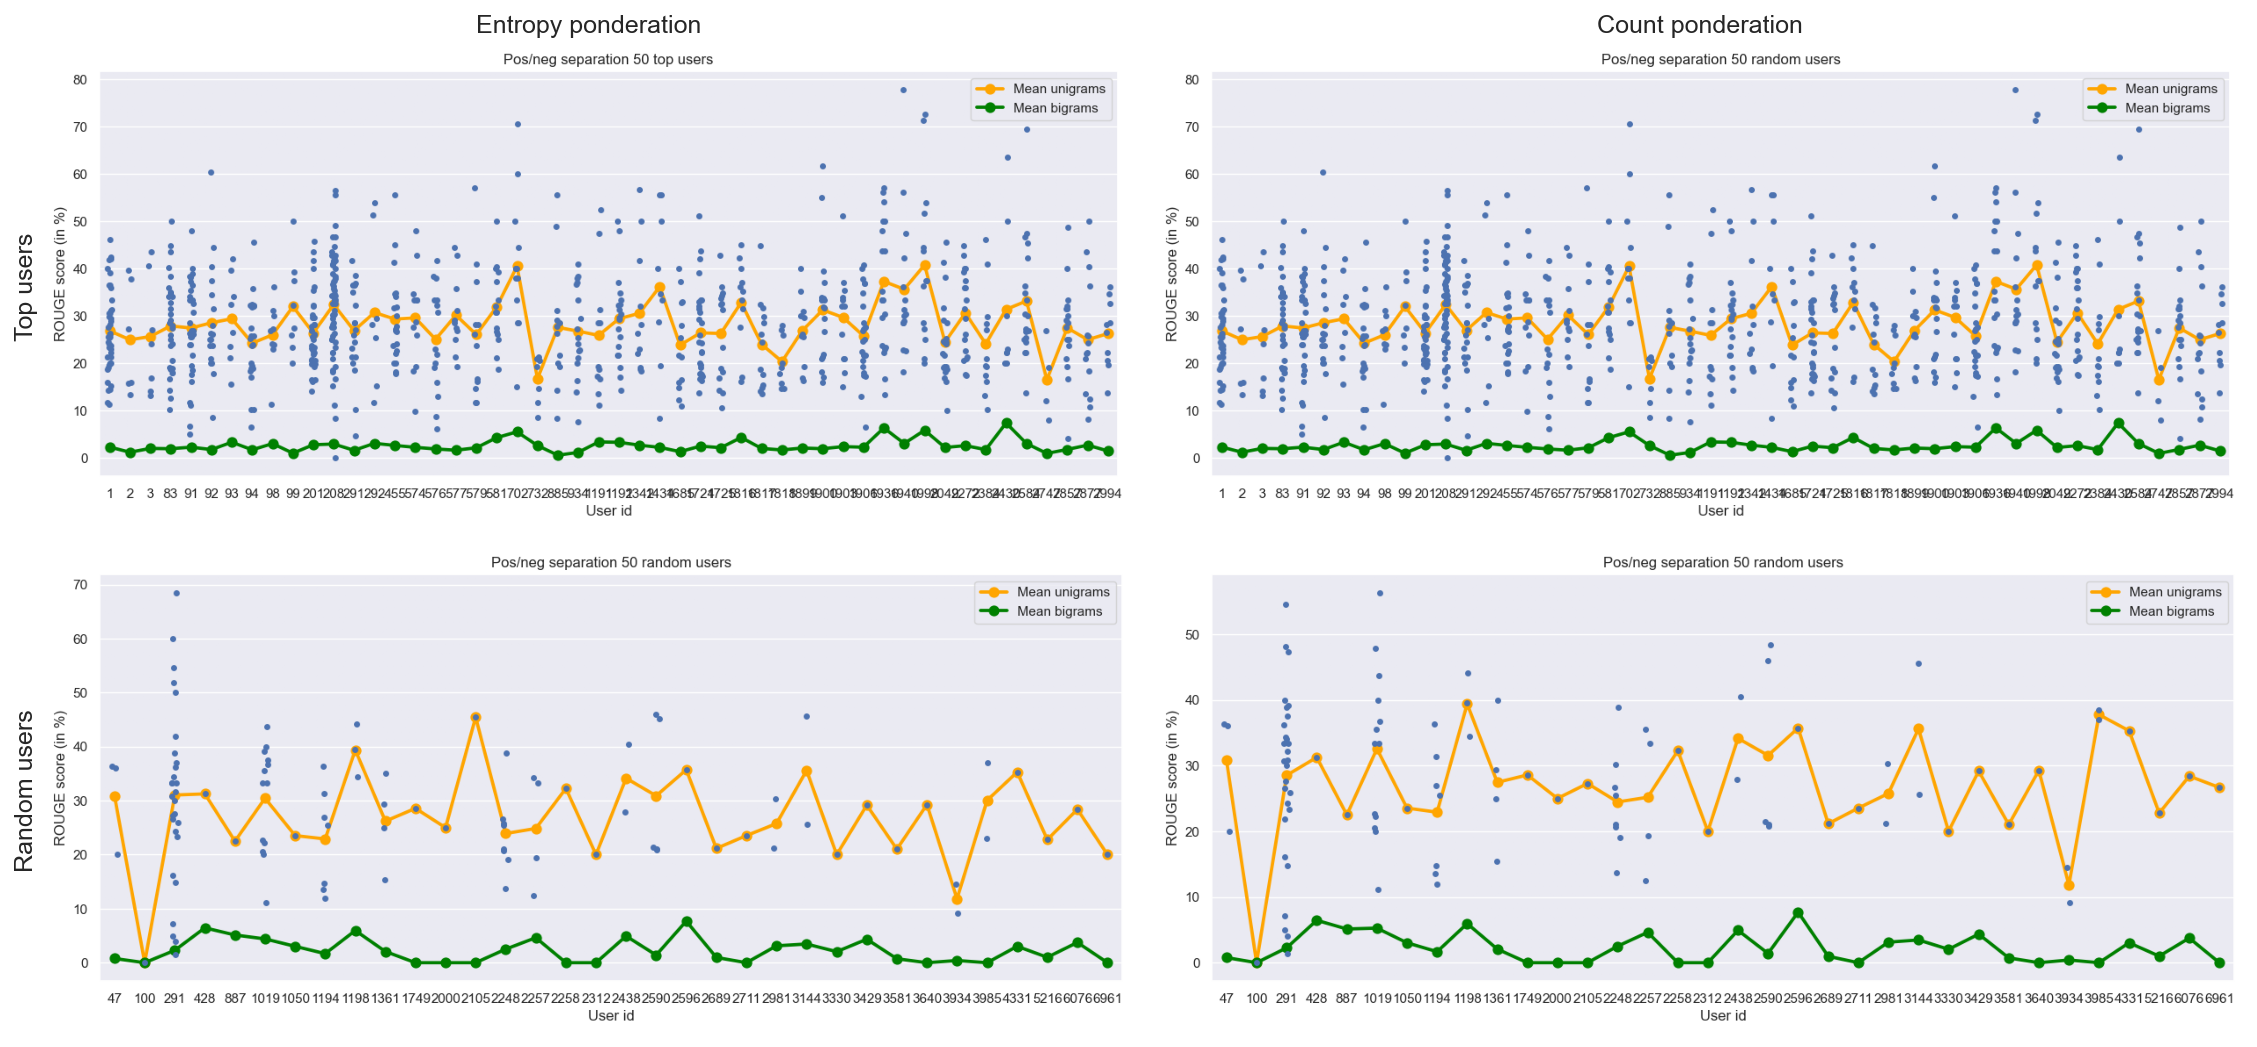

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), dpi=150)
folder = "../generated_data/embeds_eval"
im00, im10 = plt.imread(f"{folder}/entropy/pos_neg_top.png"), plt.imread(f"{folder}/entropy/pos_neg_random.png")
im01, im11 = plt.imread(f"{folder}/count/pos_neg_top.png"), plt.imread(f"{folder}/count/pos_neg_random.png")
images = [im00, im01, im10, im11]

for i, j in product(range(2), repeat=2):
    print(i, j)
    axes[i, j].imshow(images[i * 2 + j])
    axes[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axes[i, j].grid(False)
plt.tight_layout()

axes[0, 0].set_title("Entropy ponderation")
axes[0, 0].set_ylabel("Top users")

axes[0, 1].set_title("Count ponderation")

axes[1, 0].set_ylabel("Random users")

## No pos/neg separation

Text(0.5, 1.0, 'Count ponderation')

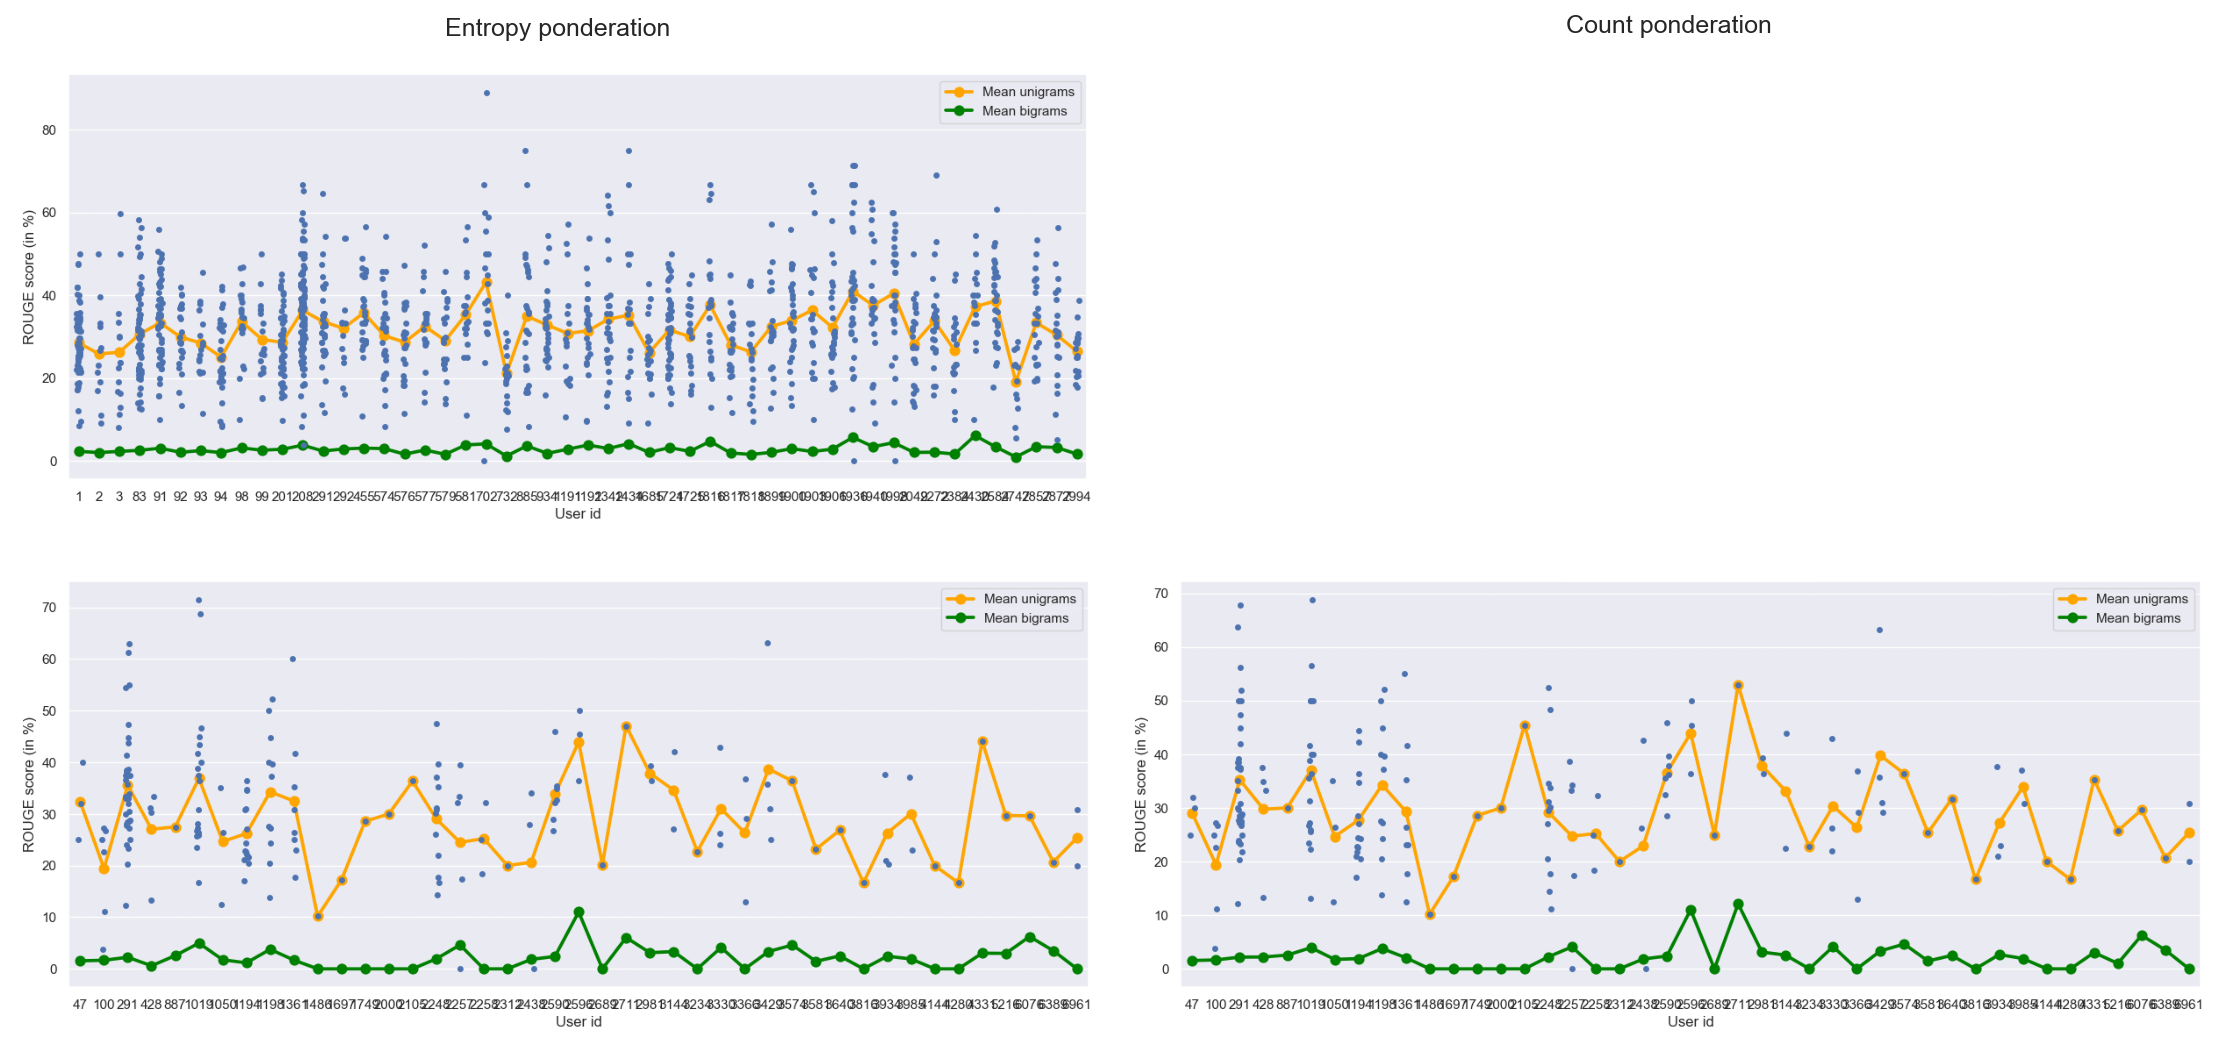

In [101]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), dpi=150)
folder = "../generated_data/embeds_eval"
im00, im10 = plt.imread(f"{folder}/entropy/all_top.png"), plt.imread(f"{folder}/entropy/all_random.png")
im11 = plt.imread(f"{folder}/count/all_random.png")
images = [im00, im10, im11]

for i, j in product(range(2), repeat=2):
    if i == 0 and j == 1:
        axes[i, j].set_axis_off()
    else:
        axes[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axes[i, j].grid(False)

axes[0, 0].imshow(images[0])
axes[1, 0].imshow(images[1])
axes[1, 1].imshow(images[2])
plt.tight_layout()

axes[0, 0].set_title("Entropy ponderation")
axes[0, 1].set_title("Count ponderation")

# Qualitative analysis

## Pos/neg separation

**User 0, Game 9146**

In [28]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 0) & (rev_filter["Game id"] == 9146)]["Comment body"].item(), width=100))

Très bien vu, Monsieur Sing ! Depuis votre console de Cap Canaveral, vous avez fort bien réussi à
marier le jeu de plis et le jeu coopératif. Il faut aimer les jeux de plis, certes. Mais pour ceux
qui n'aiment pas, l'aspect coopératif / puzzle-game pourrait prendre le dessus. Il faut aimer les
jeux coopératifs, d'accord. Mais pour ceux qui n'aiment pas, cela reste un vrai jeu de plis avec une
forme d'annonce. Au lieu d'avoir le "cul entre deux chaises", l'alliance renforce la somme des deux
aspects. Il faut même parfois se retenir, comme vous le diront les "ultras d'Hanabi", de ne pas
soulever un sourcil ou de s'exclamer d'un "OOOuuuh oui, trop bien !" lorsqu'un pli se passe comme
vous l'aviez prévu ! Parce que, qu'on le veuille ou non, ce sont des communications qui donnent des
infos supplémentaires simplifiant potentiellement la teneur du défi. Pourtant quel délice de vivre
entre amis ces regards lourds de sens, mais potentiellement incompréhensible, puisque l'informations
n'est que 

**All $3$ similar clusters**

In [29]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
game 9146 number of similar users comments 40 n clusters 3 phrases per cluster 1 1
Nb tokens: 281
Voici une possible commentaire sur le board game :

"Je pense que nous avons trouvé un trésor ! 'Il va falloir agrandir la capsule' pour que nous
puissions exploiter toutes les possibilités de jeu, car 'il va alors falloir s'étendre' dans les
différents plans d'action. En tout cas, il faudra 'faire avec' une certaine dose de stratégie et de
ruse, car c'est un peu 'ruser' pour gagner contre ses adversaires. Mais en fin de compte, ce jeu est
vraiment 'très malin', avec des mécanismes qui vous feront 'se creuser les méninges' pour comprendre
comment jouer correctement. C'est un excellent exemple du genre de jeu qui va faire entrer encore
plus de monde dans le monde merveilleux du jeu de société moderne, où la coopération et la
compétition se mélangent pour créer une expérience unique. Et avec ses missions à remplir et son
système de pli ul

**User 1, Game 3370**

In [107]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 1) & (rev_filter["Game id"] == 8444)]["Comment body"].item(), width=100))

Small islands avec ses belles couleurs et son principe de tuiles à poser trompe d’entrée le joueur
qui n’ y voit qu’un énième jeu à la Carcassonne (moi). Un quart de partie plus tard on s’aperçoit
que l’on a fait fausse route et que le jeu vaut bien mieux que cet hâtif à priori. Car ici on
remplit les objectifs à chaque fin de manche, et cela va très vite. Pas la peine de faire l’île la
plus grande, il faut multiplier les lieux pour scorer un max. Un jeu plus profond que l’on croit, et
sur lequel on revient en mode « cette fois on est prévenu, ce ne sera pas la même !»


**Pos/neg**

In [106]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 1, 8444
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 0, pos : 1 (1 hidden)
Init 4
game 8444 number of similar users comments 40 n clusters 4 phrases per cluster 1 Nb of selected phrases 12
1
Nb tokens: 354
Voici une possible commentaire du joueur :

"Joli petit jeu familial de pose de tuiles dans un univers fleuri et ensoleillé, pour ce petit jeu
de pose de tuiles sans prétention, qui ravira la famille réunie. Je le mettrais dans la lignée de
Carcassone : jeu familial de pose de tuiles ! Une variante propose des cartes objectifs modulables
ainsi qu'un mode solo. Et aussi une machine à variantes (du genre donner la carte au joueur plutôt
que ne faire que la montrer. - Les cartes Change sont un petit plus et permettront une adaptabilité
plus importante. Les règles sont simples : valider et scorer au mieux sa carte objectif à chaque
manche en plaçant stratégiquement ses tuiles ou jetons. On joue une manche jusqu'à ce que le nombre
de cartes placées dans chaque colonne soit égal ou supérieur à la valeur des ob

**No pos/neg, count**

In [110]:
clusters_weights = cluster_weight_count(comments_clusters)

user, game = 1, 8444
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, comments_clusters, comments_clusters,
                                clusters_weights, clusters_weights, all_centroids, all_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="count")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 0, pos : 1 (1 hidden)
Init 6
game 8444 number of similar users comments 48 n clusters 6 phrases per cluster 1 Nb of selected phrases 12
1
Nb tokens: 415
Voici un commentaire possible :

"Je suis vraiment impressionné par ce charmant jeu de pose de tuiles, 'Small Islands' ! La réflexion
tranquille et l'élégance sont bien présentes dans le gameplay, qui offre une sensation de fraîcheur
et de fluidité. Les règles sont simples, mais cela ne signifie pas que le jeu est prévisible.
Lorsque vous arrivez sur les îles des autres joueurs, vous devrez partagez vos tuiles et vous
adapter à la situation. Le principe de base est simple : valider et scorer au mieux votre carte
objectif en plaçant vos tuiles ou jetons de manière stratégique. Mais ce qui rend ce jeu vraiment
intéressant, c'est le mode solo et les cartes objectifs modulables qui vous permettent de jouer à
votre rythme et de chasser les énigmes. Donc, laissez-lui une chance à 'Small Islands' ! Vous allez
a

**User 0, Game 9146**

In [120]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 0) & (rev_filter["Game id"] == 9146)]["Comment body"].item(), width=100))

Très bien vu, Monsieur Sing ! Depuis votre console de Cap Canaveral, vous avez fort bien réussi à
marier le jeu de plis et le jeu coopératif. Il faut aimer les jeux de plis, certes. Mais pour ceux
qui n'aiment pas, l'aspect coopératif / puzzle-game pourrait prendre le dessus. Il faut aimer les
jeux coopératifs, d'accord. Mais pour ceux qui n'aiment pas, cela reste un vrai jeu de plis avec une
forme d'annonce. Au lieu d'avoir le "cul entre deux chaises", l'alliance renforce la somme des deux
aspects. Il faut même parfois se retenir, comme vous le diront les "ultras d'Hanabi", de ne pas
soulever un sourcil ou de s'exclamer d'un "OOOuuuh oui, trop bien !" lorsqu'un pli se passe comme
vous l'aviez prévu ! Parce que, qu'on le veuille ou non, ce sont des communications qui donnent des
infos supplémentaires simplifiant potentiellement la teneur du défi. Pourtant quel délice de vivre
entre amis ces regards lourds de sens, mais potentiellement incompréhensible, puisque l'informations
n'est que 

**Choose clusters based on entropy 50/50, pos/neg**

In [122]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 3
game 9146 number of similar users comments 40 n clusters 3 phrases per cluster 1 Nb of selected phrases 15
1
Nb tokens: 281
Voici une possible commentaire des utilisateurs :

"Je trouve que le jeu est vraiment très malin et tendu ! Il va falloir faire avec les règles un peu
compliquées, mais ça vaut la peine. En tout cas, il faudra se creuser les méninges pour comprendre
toutes les combinaisons possibles. C'est assez malin, et j'aime ça ! Le genre de jeu qui va faire
entrer encore plus de monde dans le monde merveilleux du jeu de société moderne est ici, avec un
excellent jeu de pli ultra classique qui allie jeu de développement et d'échange dans un mélange
très réussi. Un grand classique, alors !"


**Choose clusters based on count 50/50, pos/neg**

In [121]:
pos_clusters_weights = cluster_weight_count(pos_comments_clusters)
neg_clusters_weights = cluster_weight_count(neg_comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="count")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 3
game 9146 number of similar users comments 40 n clusters 3 phrases per cluster 1 Nb of selected phrases 15
1
Nb tokens: 281
Voici une possible commentaire d'un joueur sur un board game :

"Ce grand classique allie jeu de développement et d'échange dans un mélange très réussi. Un
excellent jeu de pli ultra classique avec une couche de coopération sur fond de missions à remplir.
Le genre de jeu qui va faire entrer encore plus de monde dans le monde merveilleux du jeu de société
moderne. Mais c'est très tendu, il va falloir ruser et s'étendre pour gagner ! Il va falloir
agrandir la capsule pour trouver les meilleures stratégies. En tout cas, il faudra se creuser les
méninges pour comprendre toutes les règles et combinaisons possibles. Mais c'est vraiment très malin
et très retors, ca rajoute une dimension supplémentaire au jeu en ajoutant plus de combinaisons
possibles. Et bien sûr, un jeu qui donne envie de rentrer dans le mond

**Choose clusters based on count 50/50, no pos/neg**

In [127]:
clusters_weights = cluster_weight_count(comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, comments_clusters, comments_clusters,
                                clusters_weights, clusters_weights, all_centroids, all_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="count")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 8
game 9146 number of similar users comments 64 n clusters 8 phrases per cluster 1 Nb of selected phrases 16
1
Nb tokens: 380
D'après mon avis complet sur le site L'emeeplejaune (Lien ici), je peux dire que ce jeu est une
véritable merveille du monde merveilleux du jeu de société moderne ! Il faut agrandir la capsule
pour laisser place à sa grande complexité et à ses mécanismes d'affrontements classiques qui
fonctionnent parfaitement. C'est un jeu ultra-classique avec une couche de coopération sur fond de
missions à remplir, ce qui en fait un excellent choix pour les fans de jeux de société.

Mais attention, il faut être très malin et très retors pour en tirer toutes les bénéfices ! Le jeu
est étonnant et détonnant, comme un grand coup de tonnerre dans le ciel ludique. Il est également
coopératif indispensable aux sensations différentes, déroutantes et envoutantes.

Je dirais que ce jeu est un véritable chef-d'œuvre dans une to